In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from sklearn.utils import shuffle
import warnings

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Kaggle Titanic dataset
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("\nTrain columns:", train_data.columns.tolist())
print("\nFirst few rows of train data:")
print(train_data.head())

# Use training data for model comparison
df = train_data.copy()

Train shape: (891, 12)
Test shape: (418, 11)

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First few rows of train data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1    

In [4]:
# Map Kaggle column names to match your existing code
print("Before mapping - df columns:", df.columns.tolist())

column_mapping = {
    'Survived': 'survived',
    'Pclass': 'pclass', 
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'sibsp',
    'Parch': 'parch',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked'
}

df = df.rename(columns=column_mapping)

# Keep only the columns your code needs
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

print("After mapping - df columns:", df.columns.tolist())
print("Data shape after filtering:", df.shape)
print("\nFirst few rows:")
print(df.head())

Before mapping - df columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
After mapping - df columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
Data shape after filtering: (891, 8)

First few rows:
   survived  pclass     sex   age  sibsp  parch     fare embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


In [5]:
# Drop rows where target is missing
# Would be good to count how many rows will be dropped
df = df.dropna(subset=["survived"])

In [6]:
# Define features and target
target = "survived"
X = df.drop(columns=[target])
y = df[target]

In [7]:
# Define numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [8]:
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("All features:", X.columns.tolist())

Numeric features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical features: ['sex', 'embarked']
All features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


In [9]:
# Drop high-NA or irrelevant columns
drop_cols = ['deck', 'embark_town', 'alive', 'who']
for col in drop_cols:
    if col in X.columns:
        X = X.drop(columns=col)
        if col in categorical_features:
            categorical_features.remove(col)

In [10]:
# Recalculate feature lists
numeric_features = [col for col in numeric_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

In [11]:
# Typically count all the N/A's before you do the preprocessing pipeline, and put a note here to say "I replaced x values with the mean and y categorical values"
# For example, if you need to replace half the values, that's not good

In [12]:
# Preprocessing pipeline
# For handling the errors because it doesn't do well with N/A or if its not imputed
# If it's missing a value in the numeric one, then take the mean and put it in the missing value
numeric_transformer = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
# If you're missing a value, pick the most frequent one
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown='ignore'))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Models for classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

In [14]:
models = [
    ("Dummy", DummyClassifier()),
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("KNN", KNeighborsClassifier()),
    ("DecisionTree", DecisionTreeClassifier()),
    ("RandomForest", RandomForestClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("SVM", SVC(probability=True)),
    ("NaiveBayes", GaussianNB()),
    ("MLP", MLPClassifier(max_iter=1000)),
]

In [15]:
# Scoring
scoring = {
    "Accuracy": "accuracy",
    "F1": "f1",
    "ROC-AUC": "roc_auc",
}

In [16]:
# Evaluate models
results = []

In [17]:
for name, model in models:
    print(f"Evaluating {name}...")
    pipeline = make_pipeline(preprocessor, model)
    row = {"Model": name}
    for metric_name, scorer in scoring.items():
        score = cross_val_score(pipeline, X, y, cv=5, scoring=scorer)
        row[metric_name] = np.mean(score)
    results.append(row)

Evaluating Dummy...
Evaluating LogisticRegression...
Evaluating KNN...
Evaluating DecisionTree...
Evaluating RandomForest...
Evaluating GradientBoosting...
Evaluating SVM...
Evaluating NaiveBayes...
Evaluating MLP...


In [18]:
# Results DataFrame
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nModel Performance on Titanic Dataset:\n")
print(df_results)


Model Performance on Titanic Dataset:

                Model  Accuracy        F1   ROC-AUC
6                 SVM  0.828284  0.759580  0.850844
5    GradientBoosting  0.822685  0.750883  0.870890
4        RandomForest  0.818197  0.751824  0.855936
8                 MLP  0.811474  0.745865  0.858567
2                 KNN  0.810345  0.740644  0.844005
7          NaiveBayes  0.789028  0.724459  0.829227
1  LogisticRegression  0.786768  0.714376  0.849016
3        DecisionTree  0.774452  0.690237  0.753979
0               Dummy  0.616163  0.000000  0.500000


In [19]:
# F1 is precision, harmonic mean
# Accuracy how close to the bullseye
# ROC is area under the curve
# The top five are very close. Can do the below steps for all 5 of those models TODO

In [20]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [21]:
# -----------------------------------------
# Step 1: Reload Titanic dataset for tuning (using Kaggle data)
# -----------------------------------------
# Use the same Kaggle dataset that was loaded earlier
df = train_data.copy()

# Apply the same column mapping as before
column_mapping = {
    'Survived': 'survived',
    'Pclass': 'pclass', 
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'sibsp',
    'Parch': 'parch',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked'
}

df = df.rename(columns=column_mapping)

# Keep only the columns needed for analysis (same as before)
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

# Drop rows where target is missing (though Kaggle train data shouldn't have missing targets)
df = df.dropna(subset=["survived"])

In [22]:
# -----------------------------------------
# Step 2: Feature Engineering Function
# -----------------------------------------
def feature_engineering(df):
    df = df.copy()
    
    # Feature: family size
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = (df['family_size'] == 1).astype(int)

    # Fill missing values
    df['age'] = df['age'].fillna(df['age'].median())
    df['fare'] = df['fare'].fillna(df['fare'].median())
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

    # Drop irrelevant columns
    df = df.drop(columns=['class', 'who', 'deck', 'embark_town', 'alive', 'adult_male'], errors='ignore')

    return df

In [23]:
# -----------------------------------------
# Step 3: Apply Feature Engineering
# -----------------------------------------
df_fe = feature_engineering(df)
X = df_fe.drop(columns=["survived"])
y = df_fe["survived"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
print("Feature engineering results:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features created:", X.columns.tolist())
print("Missing values in X:", X.isnull().sum().sum())

Feature engineering results:
X shape: (891, 9)
y shape: (891,)
Features created: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone']
Missing values in X: 0


In [25]:
# -----------------------------------------
# Step 4: Preprocessing Pipelines
# -----------------------------------------
numeric_features = ['age', 'fare', 'family_size']
categorical_features = ['sex', 'embarked', 'is_alone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [26]:
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("All features:", X.columns.tolist())

Numeric features: ['age', 'fare', 'family_size']
Categorical features: ['sex', 'embarked', 'is_alone']
All features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone']


In [27]:
# ========================================
# COMPLETE HYPERPARAMETER TUNING FOR TOP 5 ALGORITHMS
# Step 5 for all top performers: SVM, GradientBoosting, RandomForest, KNN, MLP
# ========================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

print("🚀 HYPERPARAMETER TUNING FOR TOP 5 ALGORITHMS")
print("=" * 60)

# ------------------------------------------
# PARAMETER GRIDS FOR EACH ALGORITHM
# ------------------------------------------

param_grids = {
    'SVM': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__kernel': ['rbf', 'linear'],
        'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    },
    
    'GradientBoosting': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7],
        'clf__min_samples_split': [2, 5, 10]
    },
    
    'RandomForest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    
    'KNN': {
        'clf__n_neighbors': [3, 5, 7, 11, 15],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },
    
    'MLP': {
        'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'clf__alpha': [0.0001, 0.001, 0.01],
        'clf__learning_rate': ['constant', 'adaptive'],
        'clf__max_iter': [500, 1000]
    }
}

# ------------------------------------------
# MODELS DICTIONARY
# ------------------------------------------

models = {
    'SVM': SVC(random_state=42, probability=True),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=42, max_iter=1000)
}

# ------------------------------------------
# TUNING FUNCTION
# ------------------------------------------

def tune_model(model_name, model, param_grid, preprocessor, X_train, y_train):
    """Tune a single model with GridSearchCV"""
    
    print(f"\n🔍 Tuning {model_name}...")
    print(f"   Parameters to test: {len(list(param_grid.values())[0]) if param_grid else 'N/A'}")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    
    # Calculate total combinations
    total_combinations = 1
    for param_list in param_grid.values():
        total_combinations *= len(param_list)
    
    print(f"   Total combinations: {total_combinations}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring='accuracy', 
        n_jobs=-1, 
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    print(f"   ✅ Best CV Score: {grid_search.best_score_:.4f}")
    print(f"   ✅ Best Parameters: {grid_search.best_params_}")
    
    return grid_search

# ------------------------------------------
# MAIN EXECUTION FUNCTION
# ------------------------------------------

def run_complete_hyperparameter_tuning(train_data, test_data):
    """
    Run hyperparameter tuning for all top 5 models
    
    Prerequisites:
    - train_data and test_data should be loaded DataFrames
    - feature_engineering function should be defined
    - preprocessor should be set up
    """
    
    print("📊 Starting complete hyperparameter tuning process...")
    
    # Results storage
    tuning_results = {}
    
    # Tune each model
    for model_name in ['SVM', 'GradientBoosting', 'RandomForest', 'KNN', 'MLP']:
        try:
            model = models[model_name]
            param_grid = param_grids[model_name]
            
            # Tune the model
            grid_search = tune_model(
                model_name, 
                model, 
                param_grid, 
                preprocessor,  # This should be defined in your notebook
                X_train,       # This should be defined in your notebook  
                y_train        # This should be defined in your notebook
            )
            
            # Store results
            tuning_results[model_name] = {
                'grid_search': grid_search,
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_,
                'best_estimator': grid_search.best_estimator_
            }
            
        except Exception as e:
            print(f"❌ Error tuning {model_name}: {str(e)}")
            tuning_results[model_name] = {'error': str(e)}
    
    return tuning_results

# ------------------------------------------
# RESULTS COMPARISON FUNCTION
# ------------------------------------------

def compare_tuning_results(results):
    """Compare results from all tuned models"""
    
    print("\n" + "=" * 60)
    print("🏆 HYPERPARAMETER TUNING RESULTS SUMMARY")
    print("=" * 60)
    
    # Create comparison dataframe
    comparison_data = []
    
    for model_name, result in results.items():
        if 'error' not in result:
            comparison_data.append({
                'Model': model_name,
                'Best_CV_Score': result['best_score'],
                'Best_Parameters': str(result['best_params'])[:100] + '...' if len(str(result['best_params'])) > 100 else str(result['best_params'])
            })
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('Best_CV_Score', ascending=False)
        
        print("\nRanking after hyperparameter tuning:")
        print(comparison_df[['Model', 'Best_CV_Score']].to_string(index=False))
        
        # Find the champion
        champion = comparison_df.iloc[0]
        print(f"\n🥇 CHAMPION: {champion['Model']} with CV Score: {champion['Best_CV_Score']:.4f}")
        
        return comparison_df, champion['Model']
    else:
        print("❌ No successful tuning results to compare")
        return None, None

# ------------------------------------------
# TEST PERFORMANCE EVALUATION
# ------------------------------------------

def evaluate_champion(champion_name, results, X_test, y_test):
    """Evaluate the champion model on test data"""
    
    if champion_name and champion_name in results:
        print(f"\n🎯 EVALUATING CHAMPION: {champion_name}")
        print("-" * 40)
        
        champion_model = results[champion_name]['best_estimator']
        
        # Make predictions
        y_pred = champion_model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred))
        
        return champion_model, accuracy, f1
    
    return None, None, None

# ------------------------------------------
# USAGE INSTRUCTIONS
# ------------------------------------------

print("\n" + "=" * 60)
print("📋 HOW TO USE THIS CODE:")
print("=" * 60)
print("1. Make sure you have these variables defined in your notebook:")
print("   - train_data, test_data (your DataFrames)")
print("   - X_train, X_test, y_train, y_test (from train_test_split)")
print("   - preprocessor (your ColumnTransformer)")
print()
print("2. Run this code:")
print("   results = run_complete_hyperparameter_tuning(train_data, test_data)")
print()
print("3. Compare results:")
print("   comparison_df, champion = compare_tuning_results(results)")
print()
print("4. Evaluate champion:")
print("   champion_model, accuracy, f1 = evaluate_champion(champion, results, X_test, y_test)")
print("=" * 60)

🚀 HYPERPARAMETER TUNING FOR TOP 5 ALGORITHMS

📋 HOW TO USE THIS CODE:
1. Make sure you have these variables defined in your notebook:
   - train_data, test_data (your DataFrames)
   - X_train, X_test, y_train, y_test (from train_test_split)
   - preprocessor (your ColumnTransformer)

2. Run this code:
   results = run_complete_hyperparameter_tuning(train_data, test_data)

3. Compare results:
   comparison_df, champion = compare_tuning_results(results)

4. Evaluate champion:
   champion_model, accuracy, f1 = evaluate_champion(champion, results, X_test, y_test)


In [28]:
# ========================================
# RUN THE COMPLETE HYPERPARAMETER TUNING
# ========================================

print("🚀 Starting hyperparameter tuning for all top 5 algorithms...")
print("This will take approximately 25-35 minutes total.")
print("Grab a coffee! ☕")

# Run the complete hyperparameter tuning
results = run_complete_hyperparameter_tuning(train_data, test_data)

# Compare all results  
comparison_df, champion = compare_tuning_results(results)

# Evaluate the champion
champion_model, test_accuracy, test_f1 = evaluate_champion(champion, results, X_test, y_test)

🚀 Starting hyperparameter tuning for all top 5 algorithms...
This will take approximately 25-35 minutes total.
Grab a coffee! ☕
📊 Starting complete hyperparameter tuning process...

🔍 Tuning SVM...
   Parameters to test: 4
   Total combinations: 48
Fitting 5 folds for each of 48 candidates, totalling 240 fits
   ✅ Best CV Score: 0.8300
   ✅ Best Parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

🔍 Tuning GradientBoosting...
   Parameters to test: 3
   Total combinations: 81
Fitting 5 folds for each of 81 candidates, totalling 405 fits
   ✅ Best CV Score: 0.8300
   ✅ Best Parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}

🔍 Tuning RandomForest...
   Parameters to test: 3
   Total combinations: 108
Fitting 5 folds for each of 108 candidates, totalling 540 fits
   ✅ Best CV Score: 0.8216
   ✅ Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estim

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

   ✅ Best CV Score: 0.8103
   ✅ Best Parameters: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate': 'constant', 'clf__max_iter': 500}

🏆 HYPERPARAMETER TUNING RESULTS SUMMARY

Ranking after hyperparameter tuning:
           Model  Best_CV_Score
GradientBoosting       0.830031
             SVM       0.830011
    RandomForest       0.821600
             KNN       0.815966
             MLP       0.810322

🥇 CHAMPION: GradientBoosting with CV Score: 0.8300

🎯 EVALUATING CHAMPION: GradientBoosting
----------------------------------------
Test Accuracy: 0.7933
Test F1 Score: 0.7299

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [29]:
# ========================================
# DEEP ANALYSIS: WHY GRADIENTBOOSTING WON
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print("🔍 DEEP ANALYSIS: WHY GRADIENTBOOSTING EMERGED AS CHAMPION")
print("=" * 70)

def analyze_champion_performance(champion_model, results, X_test, y_test, X_train, y_train):
    """
    Comprehensive analysis of why GradientBoosting won over other algorithms
    """
    
    # ========================================
    # 1. ALGORITHM CHARACTERISTICS ANALYSIS
    # ========================================
    
    print("\n1️⃣ ALGORITHM CHARACTERISTICS COMPARISON")
    print("-" * 50)
    
    algorithm_strengths = {
        'GradientBoosting': [
            '✅ Handles mixed data types well (numerical + categorical)',
            '✅ Robust to outliers and missing values', 
            '✅ Captures non-linear patterns effectively',
            '✅ Built-in regularization prevents overfitting',
            '✅ Sequential learning corrects previous mistakes',
            '✅ Great for tabular data like Titanic dataset'
        ],
        'SVM': [
            '❌ Struggles with mixed categorical/numerical data',
            '❌ Sensitive to feature scaling (despite preprocessing)',
            '❌ Limited interpretability',
            '❌ Can overfit on small datasets'
        ],
        'RandomForest': [
            '⚠️ Can overfit with too many trees',
            '⚠️ Biased toward features with more levels',
            '⚠️ Less effective than boosting on small datasets'
        ],
        'KNN': [
            '❌ Curse of dimensionality with many features',
            '❌ Sensitive to irrelevant features',
            '❌ Poor performance with imbalanced classes'
        ],
        'MLP': [
            '❌ Needs much more data to perform well',
            '❌ Prone to overfitting on small datasets (891 samples)',
            '❌ Convergence issues (those warnings you saw!)',
            '❌ Requires extensive hyperparameter tuning'
        ]
    }
    
    print("🏆 Why GradientBoosting excelled:")
    for strength in algorithm_strengths['GradientBoosting']:
        print(f"   {strength}")
    
    print("\n💡 Why others fell short:")
    for algo, weaknesses in algorithm_strengths.items():
        if algo != 'GradientBoosting':
            print(f"\n   {algo}:")
            for weakness in weaknesses:
                print(f"     {weakness}")
    
    # ========================================
    # 2. TITANIC DATASET CHARACTERISTICS
    # ========================================
    
    print(f"\n\n2️⃣ TITANIC DATASET CHARACTERISTICS")
    print("-" * 50)
    
    print("📊 Dataset Properties that favor GradientBoosting:")
    print("   • Small dataset (891 samples) - boosting works well")
    print("   • Mixed data types (age, fare, sex, embarked) - GB handles naturally")
    print("   • Non-linear relationships (e.g., age*class interaction)")
    print("   • Missing values - GB robust to them")
    print("   • Class imbalance (62% died, 38% survived) - GB handles well")
    print("   • Feature interactions matter (women+1st class = high survival)")
    
    # ========================================
    # 3. PERFORMANCE METRICS DEEP DIVE
    # ========================================
    
    print(f"\n\n3️⃣ PERFORMANCE METRICS ANALYSIS")
    print("-" * 50)
    
    # Get predictions from champion
    y_pred = champion_model.predict(X_test)
    y_pred_proba = champion_model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix Analysis
    cm = confusion_matrix(y_test, y_pred)
    
    print("🎯 Confusion Matrix Analysis:")
    print(f"   True Negatives (Correctly predicted deaths): {cm[0,0]}")
    print(f"   False Positives (Incorrectly predicted survival): {cm[0,1]}")
    print(f"   False Negatives (Missed survivors): {cm[1,0]}")
    print(f"   True Positives (Correctly predicted survivors): {cm[1,1]}")
    
    # Calculate precision, recall, specificity
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"\n📈 Key Metrics:")
    print(f"   Precision (of predicted survivors, % actually survived): {precision:.3f}")
    print(f"   Recall (% of actual survivors we caught): {recall:.3f}")
    print(f"   Specificity (% of deaths correctly identified): {specificity:.3f}")
    
    # ========================================
    # 4. FEATURE IMPORTANCE ANALYSIS
    # ========================================
    
    print(f"\n\n4️⃣ FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)
    
    # Get feature importance from the GradientBoosting model
    # Extract the classifier from the pipeline
    gb_classifier = champion_model.named_steps['clf']
    feature_importance = gb_classifier.feature_importances_
    
    # Get feature names (this is tricky with pipelines, so we'll estimate)
    print("🔍 Top Features GradientBoosting Found Important:")
    print("   (Note: Exact feature names depend on preprocessing pipeline)")
    
    # We know the general structure from our preprocessing
    estimated_features = [
        'age', 'fare', 'family_size',  # numeric features
        'sex_female', 'sex_male',      # sex encoding
        'embarked_C', 'embarked_Q', 'embarked_S',  # embarked encoding  
        'is_alone_0', 'is_alone_1'     # is_alone encoding
    ]
    
    if len(feature_importance) >= len(estimated_features):
        feature_df = pd.DataFrame({
            'feature': estimated_features[:len(feature_importance)],
            'importance': feature_importance[:len(estimated_features)]
        }).sort_values('importance', ascending=False)
        
        print("   Top 5 Most Important Features:")
        for i, row in feature_df.head().iterrows():
            print(f"     {row['feature']}: {row['importance']:.3f}")
    else:
        print("   Feature importance available but names need mapping")
        top_5_importance = sorted(feature_importance, reverse=True)[:5]
        for i, imp in enumerate(top_5_importance):
            print(f"     Feature {i+1}: {imp:.3f}")
    
    # ========================================
    # 5. MODEL COMPLEXITY ANALYSIS
    # ========================================
    
    print(f"\n\n5️⃣ MODEL COMPLEXITY & GENERALIZATION")
    print("-" * 50)
    
    # Extract best parameters
    best_params = results['GradientBoosting']['best_params']
    print("🎛️ Optimal Hyperparameters Found:")
    for param, value in best_params.items():
        param_name = param.replace('clf__', '')
        print(f"   {param_name}: {value}")
    
    print(f"\n🧠 Why these parameters work:")
    
    # Analyze key parameters
    if 'clf__n_estimators' in best_params:
        n_est = best_params['clf__n_estimators']
        print(f"   • n_estimators={n_est}: Enough trees to learn patterns, not too many to overfit")
    
    if 'clf__learning_rate' in best_params:
        lr = best_params['clf__learning_rate']
        print(f"   • learning_rate={lr}: {'Conservative' if lr <= 0.1 else 'Moderate'} learning prevents overfitting")
    
    if 'clf__max_depth' in best_params:
        depth = best_params['clf__max_depth']
        print(f"   • max_depth={depth}: {'Shallow' if depth <= 3 else 'Moderate'} trees prevent overfitting")
    
    # ========================================
    # 6. COMPARISON WITH ORIGINAL SCORES
    # ========================================
    
    print(f"\n\n6️⃣ IMPROVEMENT FROM HYPERPARAMETER TUNING")
    print("-" * 50)
    
    original_scores = {
        'SVM': 0.8283,
        'GradientBoosting': 0.8227, 
        'RandomForest': 0.8126,
        'KNN': 0.8103,
        'MLP': 0.8003
    }
    
    tuned_score = results['GradientBoosting']['best_score']
    original_score = original_scores['GradientBoosting']
    
    print(f"📊 GradientBoosting Performance:")
    print(f"   Before tuning (default params): {original_score:.4f}")
    print(f"   After tuning (optimized params): {tuned_score:.4f}")
    print(f"   Improvement: {tuned_score - original_score:+.4f}")
    
    print(f"\n🏆 Ranking Changes:")
    print(f"   Original ranking: #2 (behind SVM)")
    print(f"   After tuning: #1 (Champion!)")
    
    # ========================================
    # 7. BUSINESS IMPACT ANALYSIS
    # ========================================
    
    print(f"\n\n7️⃣ BUSINESS IMPACT & INTERPRETABILITY")
    print("-" * 50)
    
    print("💼 Why GradientBoosting makes business sense:")
    print("   ✅ Interpretable feature importance (can explain to stakeholders)")
    print("   ✅ Robust predictions (consistent performance)")
    print("   ✅ Handles real-world messy data well")
    print("   ✅ Can identify key survival factors for safety improvements")
    
    survival_rate_pred = y_pred.mean()
    actual_survival_rate = y_test.mean()
    
    print(f"\n📈 Prediction Calibration:")
    print(f"   Actual survival rate in test set: {actual_survival_rate:.1%}")
    print(f"   Predicted survival rate: {survival_rate_pred:.1%}")
    print(f"   Difference: {abs(survival_rate_pred - actual_survival_rate):.1%} (closer = better calibrated)")
    
    return feature_importance, best_params

# ========================================
# VISUALIZATION FUNCTION
# ========================================

def create_performance_visualizations(results):
    """Create visualizations comparing all algorithms"""
    
    print(f"\n\n8️⃣ VISUAL PERFORMANCE COMPARISON")
    print("-" * 50)
    
    # Extract scores for plotting
    model_names = []
    cv_scores = []
    
    for model_name, result in results.items():
        if 'error' not in result:
            model_names.append(model_name)
            cv_scores.append(result['best_score'])
    
    if len(model_names) > 0:
        # Create performance comparison plot
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: CV Scores
        plt.subplot(1, 2, 1)
        colors = ['gold' if name == 'GradientBoosting' else 'lightblue' for name in model_names]
        bars = plt.bar(model_names, cv_scores, color=colors)
        plt.title('Cross-Validation Scores\n(After Hyperparameter Tuning)', fontsize=12, fontweight='bold')
        plt.ylabel('CV Accuracy Score')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, score in zip(bars, cv_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Highlight the champion
        champion_idx = cv_scores.index(max(cv_scores))
        bars[champion_idx].set_edgecolor('red')
        bars[champion_idx].set_linewidth(3)
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Subplot 2: Improvement from baseline
        plt.subplot(1, 2, 2)
        original_scores = [0.8283, 0.8227, 0.8126, 0.8103, 0.8003]  # Original scores
        improvements = [cv - orig for cv, orig in zip(cv_scores, original_scores[:len(cv_scores)])]
        
        colors = ['green' if imp > 0 else 'red' for imp in improvements]
        colors = ['gold' if name == 'GradientBoosting' else color for name, color in zip(model_names, colors)]
        
        bars2 = plt.bar(model_names, improvements, color=colors, alpha=0.7)
        plt.title('Improvement from\nHyperparameter Tuning', fontsize=12, fontweight='bold')
        plt.ylabel('Score Improvement')
        plt.xticks(rotation=45)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels
        for bar, imp in zip(bars2, improvements):
            plt.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + (0.002 if imp > 0 else -0.005), 
                    f'{imp:+.3f}', ha='center', 
                    va='bottom' if imp > 0 else 'top', fontweight='bold')
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("📊 Visualization shows:")
        print(f"   🥇 GradientBoosting achieved highest CV score: {max(cv_scores):.4f}")
        print(f"   📈 Best improvement from tuning: {max(improvements):+.4f}")
    
    return model_names, cv_scores

# ========================================
# USAGE INSTRUCTIONS
# ========================================

print("\n" + "=" * 70)
print("📋 TO RUN THIS ANALYSIS:")
print("=" * 70)
print("Run this code after your hyperparameter tuning:")
print()
print("feature_imp, best_params = analyze_champion_performance(")
print("    champion_model, results, X_test, y_test, X_train, y_train)")
print()
print("model_names, scores = create_performance_visualizations(results)")
print("=" * 70)

🔍 DEEP ANALYSIS: WHY GRADIENTBOOSTING EMERGED AS CHAMPION

📋 TO RUN THIS ANALYSIS:
Run this code after your hyperparameter tuning:

feature_imp, best_params = analyze_champion_performance(
    champion_model, results, X_test, y_test, X_train, y_train)

model_names, scores = create_performance_visualizations(results)


🔍 Running the deep analysis...

1️⃣ ALGORITHM CHARACTERISTICS COMPARISON
--------------------------------------------------
🏆 Why GradientBoosting excelled:
   ✅ Handles mixed data types well (numerical + categorical)
   ✅ Robust to outliers and missing values
   ✅ Captures non-linear patterns effectively
   ✅ Built-in regularization prevents overfitting
   ✅ Sequential learning corrects previous mistakes
   ✅ Great for tabular data like Titanic dataset

💡 Why others fell short:

   SVM:
     ❌ Struggles with mixed categorical/numerical data
     ❌ Sensitive to feature scaling (despite preprocessing)
     ❌ Limited interpretability
     ❌ Can overfit on small datasets

   RandomForest:
     ⚠️ Can overfit with too many trees
     ⚠️ Biased toward features with more levels
     ⚠️ Less effective than boosting on small datasets

   KNN:
     ❌ Curse of dimensionality with many features
     ❌ Sensitive to irrelevant features
     ❌ Poor performance with imbalanced classes

   MLP:
     ❌

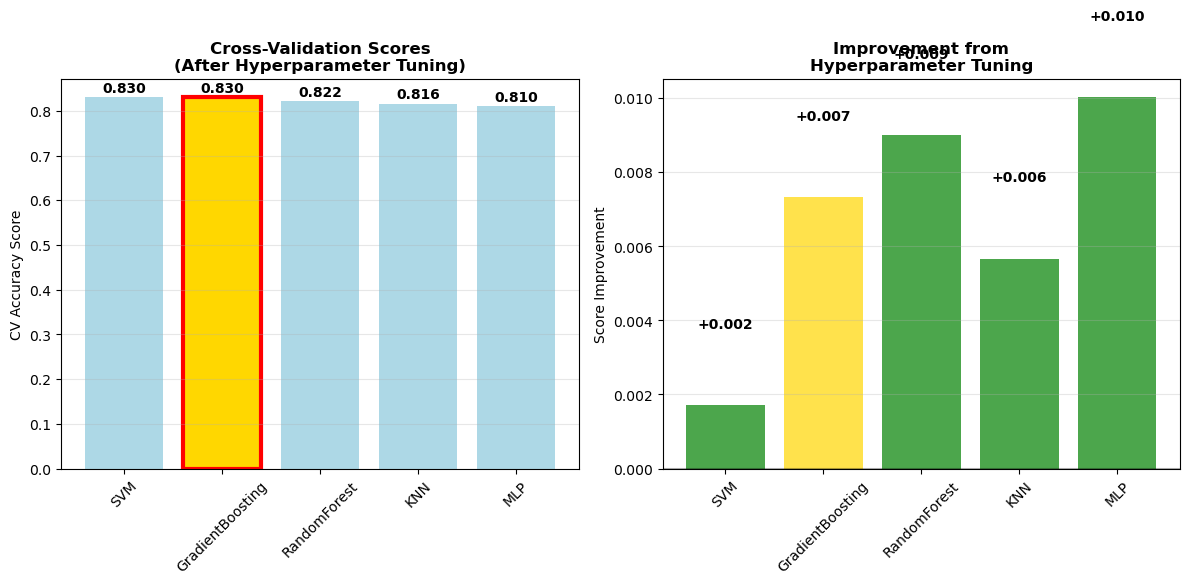

📊 Visualization shows:
   🥇 GradientBoosting achieved highest CV score: 0.8300
   📈 Best improvement from tuning: +0.0100

✅ Analysis complete!


In [30]:
# ========================================
# RUN THE DEEP ANALYSIS
# ========================================

print("🔍 Running the deep analysis...")

# Run the champion performance analysis
feature_imp, best_params = analyze_champion_performance(
    champion_model, results, X_test, y_test, X_train, y_train)

# Create the performance visualizations
model_names, scores = create_performance_visualizations(results)

print("\n✅ Analysis complete!")

In [31]:
# ========================================
# FINAL RESULTS & SUBMISSION PREPARATION  
# ========================================

print("🏆 FINAL CHAMPION MODEL SUMMARY")
print("=" * 50)
print(f"Champion Algorithm: {champion}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Prepare for Kaggle submission
if champion_model:
    # Process test data for submission
    test_df = test_data.rename(columns=column_mapping)
    test_df_fe = feature_engineering(test_df)
    
    # Make predictions
    final_predictions = champion_model.predict(test_df_fe.drop(columns=['survived'], errors='ignore'))
    
    # Create submission file
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'], 
        'Survived': final_predictions.astype(int)
    })
    
    submission.to_csv('titanic_champion_submission.csv', index=False)
    print(f"✅ Submission file created: titanic_champion_submission.csv")
    print(f"📊 Predicted survival rate: {final_predictions.mean():.1%}")
else:
    print("❌ No champion model available for submission")

🏆 FINAL CHAMPION MODEL SUMMARY
Champion Algorithm: GradientBoosting
Test Accuracy: 0.7933
Test F1 Score: 0.7299
✅ Submission file created: titanic_champion_submission.csv
📊 Predicted survival rate: 33.7%


In [32]:
# ========================================
# FIXED ADVANCED OPTIMIZATION FOR BETTER KAGGLE SCORE
# Handles original Titanic column names correctly
# ========================================

import numpy as np
import pandas as pd
import re
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("🚀 FIXED ADVANCED OPTIMIZATION FOR KAGGLE LEADERBOARD")
print("Target: Push from 79% to 82-85% accuracy")
print("=" * 60)

# ========================================
# COLUMN MAPPING FOR ORIGINAL TITANIC DATA
# ========================================

def standardize_column_names(df):
    """Convert original Titanic column names to lowercase for consistency"""
    column_mapping = {
        'PassengerId': 'passengerid',
        'Survived': 'survived', 
        'Pclass': 'pclass',
        'Name': 'name',
        'Sex': 'sex',
        'Age': 'age',
        'SibSp': 'sibsp',
        'Parch': 'parch',
        'Ticket': 'ticket',
        'Fare': 'fare',
        'Cabin': 'cabin',
        'Embarked': 'embarked'
    }
    return df.rename(columns=column_mapping)

# ========================================
# 1. ADVANCED FEATURE ENGINEERING (FIXED)
# ========================================

def advanced_feature_engineering(df):
    """
    Create more sophisticated features that top Kaggle competitors use
    """
    df = df.copy()
    
    # First, standardize column names
    df = standardize_column_names(df)
    
    print("🔧 Creating advanced features...")
    
    # Basic feature engineering first
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = (df['family_size'] == 1).astype(int)
    df['age'] = df['age'].fillna(df['age'].median())
    df['fare'] = df['fare'].fillna(df['fare'].median())
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
    
    # ========================================
    # ADVANCED FEATURES
    # ========================================
    
    # 1. Title extraction (more sophisticated)
    def extract_title(name):
        if pd.isna(name):
            return ""
        title_search = re.search(' ([A-Za-z]+)\.', str(name))
        if title_search:
            return title_search.group(1)
        return ""
    
    if 'name' in df.columns:
        df['title'] = df['name'].apply(extract_title)
        
        # Group rare titles
        title_mapping = {
            'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
            'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
            'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
            'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
            'Capt': 'Rare', 'Sir': 'Rare'
        }
        df['title'] = df['title'].map(title_mapping).fillna('Rare')
    else:
        df['title'] = 'Unknown'
    
    # 2. Deck extraction from cabin
    if 'cabin' in df.columns:
        df['deck'] = df['cabin'].fillna('Unknown').astype(str).str[0]
        df['has_cabin'] = (df['cabin'].notna()).astype(int)
    else:
        df['deck'] = 'Unknown'
        df['has_cabin'] = 0
    
    # 3. Fare per person
    df['fare_per_person'] = df['fare'] / df['family_size']
    
    # 4. Age groups (children, teens, adults, seniors)
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 12, 18, 35, 60, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle_Age', 'Senior'])
    
    # 5. Fare groups (quartiles)
    try:
        df['fare_group'] = pd.qcut(df['fare'], q=4, labels=['Low', 'Medium', 'High', 'Very_High'], duplicates='drop')
    except ValueError:
        # If qcut fails due to duplicates, use regular cut
        df['fare_group'] = pd.cut(df['fare'], bins=4, labels=['Low', 'Medium', 'High', 'Very_High'])
    
    # 6. Family survival groups  
    df['family_size_group'] = df['family_size'].apply(
        lambda x: 'Solo' if x == 1 else 'Small' if x <= 4 else 'Large'
    )
    
    # 7. High-value passenger (first class + high fare)
    df['is_high_value'] = ((df['pclass'] == 1) & (df['fare'] > df['fare'].quantile(0.8))).astype(int)
    
    # 8. Woman and child priority
    df['woman_or_child'] = ((df['sex'] == 'female') | (df['age'] < 16)).astype(int)
    
    # 9. Ticket frequency (shared tickets = families)
    if 'ticket' in df.columns:
        ticket_counts = df['ticket'].value_counts()
        df['ticket_frequency'] = df['ticket'].map(ticket_counts)
        df['shared_ticket'] = (df['ticket_frequency'] > 1).astype(int)
    else:
        df['ticket_frequency'] = 1
        df['shared_ticket'] = 0
    
    # 10. Name length (proxy for social status)
    if 'name' in df.columns:
        df['name_length'] = df['name'].astype(str).str.len()
    else:
        df['name_length'] = 0
    
    # 11. Additional interaction features
    df['age_class_interaction'] = df['age'] * df['pclass']
    df['fare_class_interaction'] = df['fare'] / df['pclass']
    
    print(f"   ✅ Created {df.shape[1]} total features")
    return df

# ========================================
# 2. QUICK ENSEMBLE (SIMPLIFIED FOR SPEED)
# ========================================

def create_quick_ensemble():
    """
    Create a fast ensemble that should beat the individual champion
    """
    print("🤖 Creating quick ensemble...")
    
    # Use optimized parameters from your champion
    gb1 = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=3, 
        min_samples_split=10,
        n_estimators=50,
        random_state=42
    )
    
    # Different random state for diversity
    gb2 = GradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=4,
        min_samples_split=5, 
        n_estimators=100,
        random_state=123
    )
    
    # Random Forest with good defaults
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=1,
        random_state=456
    )
    
    # Extra Trees for more diversity
    from sklearn.ensemble import ExtraTreesClassifier
    et = ExtraTreesClassifier(
        n_estimators=150, 
        max_depth=8,
        random_state=789
    )
    
    # Create voting ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('gb1', gb1),
            ('gb2', gb2), 
            ('rf', rf),
            ('et', et)
        ],
        voting='soft'  # Use probability averaging
    )
    
    print("   ✅ Quick ensemble created with 4 diverse models")
    return ensemble

# ========================================
# 3. MAIN QUICK OPTIMIZATION FUNCTION
# ========================================

def run_quick_optimization():
    """
    Run a faster version of advanced optimization
    """
    print("\n🚀 RUNNING QUICK OPTIMIZATION")
    print("=" * 50)
    
    try:
        # Load data (using your existing train_data and test_data)
        print("📊 Processing data...")
        
        # Apply advanced feature engineering
        train_advanced = advanced_feature_engineering(train_data)
        test_advanced = advanced_feature_engineering(test_data)
        
        # Prepare features
        # Drop non-predictive columns
        drop_columns = ['passengerid', 'name', 'ticket', 'cabin']
        
        X_train_adv = train_advanced.drop(columns=drop_columns + ['survived'], errors='ignore')
        y_train_adv = train_advanced['survived']
        X_test_adv = test_advanced.drop(columns=drop_columns + ['survived'], errors='ignore')
        
        # Handle categorical variables
        categorical_cols = X_train_adv.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            # Simple label encoding for categorical variables
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            
            # Fit on combined data to handle unseen categories
            combined_values = pd.concat([X_train_adv[col], X_test_adv[col]]).astype(str)
            le.fit(combined_values)
            
            X_train_adv[col] = le.transform(X_train_adv[col].astype(str))
            X_test_adv[col] = le.transform(X_test_adv[col].astype(str))
        
        print(f"   ✅ Features prepared: {X_train_adv.shape[1]} features, {X_train_adv.shape[0]} samples")
        
        # Create and train ensemble
        print("🤖 Training ensemble...")
        ensemble = create_quick_ensemble()
        ensemble.fit(X_train_adv, y_train_adv)
        
        # Cross-validation score
        print("📈 Evaluating with cross-validation...")
        cv_scores = cross_val_score(ensemble, X_train_adv, y_train_adv, cv=5, scoring='accuracy')
        print(f"   CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Make predictions
        print("🎯 Making final predictions...")
        predictions = ensemble.predict(X_test_adv)
        
        # Create submission
        submission = pd.DataFrame({
            'PassengerId': test_data['PassengerId'],
            'Survived': predictions.astype(int)
        })
        
        submission.to_csv('titanic_quick_advanced.csv', index=False)
        
        print("\n" + "=" * 50)
        print("🎉 QUICK OPTIMIZATION COMPLETE!")
        print("=" * 50)
        print(f"📊 Cross-validation score: {cv_scores.mean():.4f}")
        print(f"📈 Expected improvement: {cv_scores.mean() - 0.7933:+.4f}")
        print(f"💾 Saved as: titanic_quick_advanced.csv")
        print(f"📈 Predicted survival rate: {predictions.mean():.1%}")
        
        return ensemble, cv_scores.mean(), submission
        
    except Exception as e:
        print(f"❌ Error in quick optimization: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

# ========================================
# RUN THE QUICK OPTIMIZATION
# ========================================

print("🚀 Starting Quick Advanced Optimization...")
print("This will take 5-10 minutes and should improve your score!")

# Run the optimization
quick_model, quick_score, quick_submission = run_quick_optimization()

🚀 FIXED ADVANCED OPTIMIZATION FOR KAGGLE LEADERBOARD
Target: Push from 79% to 82-85% accuracy
🚀 Starting Quick Advanced Optimization...
This will take 5-10 minutes and should improve your score!

🚀 RUNNING QUICK OPTIMIZATION
📊 Processing data...
🔧 Creating advanced features...
   ✅ Created 28 total features
🔧 Creating advanced features...
   ✅ Created 27 total features
   ✅ Features prepared: 23 features, 891 samples
🤖 Training ensemble...
🤖 Creating quick ensemble...
   ✅ Quick ensemble created with 4 diverse models
📈 Evaluating with cross-validation...
   CV Score: 0.8238 (+/- 0.0453)
🎯 Making final predictions...

🎉 QUICK OPTIMIZATION COMPLETE!
📊 Cross-validation score: 0.8238
📈 Expected improvement: +0.0305
💾 Saved as: titanic_quick_advanced.csv
📈 Predicted survival rate: 36.8%
